In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Let's have a look at the dataset and how it is layed down.

The data is structured as follows:
```
content/
  train/
    _annotations.coco.json

    image1.jpg
    image2.jpg
    image3.jpg
    ...
  test/
    _annotations.coco.json

    image1.jpg
    image2.jpg
    image3.jpg
    ...
```


## Creating Data pipeline for Training on our custom dataset

Each image has corresponding bounding boxes in coco json formate.
Let's write a `torch.utils.data.Dataset` class for this dataset.

In [4]:
import json
from PIL import Image
import torch
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO
import os
import numpy as np
class myDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_path, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir( img_dir )))
        with open(ann_path,'r') as f:
            self.annotations = json.load(f)
         
    def __len__(self):
        return len(self.annotations["images"])

    def __getitem__(self, index):
        img_dir = self.img_dir
        annotations = self.annotations
        transforms = self.transforms

        file_name = annotations["images"][index]['file_name']
        img_path = os.path.join(img_dir, file_name)

        img = Image.open(img_path).convert("RGB")
        height = annotations["images"][index]['height']
        width = annotations["images"][index]['width']
        annotations =[(ann) for ann in self.annotations["annotations"] if ann['image_id'] == index]
        target = {}
        area = []
        labels = []
        masks = []
        boxes = []
        for annotation in annotations:
 
            area.append(annotation["area"])
            labels.append(annotation["category_id"])
            xmin = annotation['bbox'][0]
            xmax = annotation['bbox'][0]+annotation['bbox'][2]
            ymin = annotation['bbox'][1]
            ymax = annotation['bbox'][1]+annotation['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target["boxes"] = boxes
        target["labels"] = torch.as_tensor(labels)
        target["image_id"] = torch.tensor([index])
        target["area"] = torch.tensor(area)
        target["iscrowd"] = torch.zeros(len(annotations), dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [5]:
dataset = myDataset('/content/train',"/content/train/_annotations.coco.json")#,get_transform(train=True))
dataset[0]

(<PIL.Image.Image image mode=RGB size=512x512 at 0x7F9639AF6950>,
 {'area': tensor([3376, 3200, 3914, 3376, 3424, 3024, 2100, 1404, 1290,  900, 3568]),
  'boxes': tensor([[236., 253., 447., 269.],
          [180., 261., 380., 277.],
          [137., 262., 343., 281.],
          [196., 236., 407., 252.],
          [171., 223., 385., 239.],
          [107., 212., 323., 226.],
          [ 59., 205., 269., 215.],
          [ 53., 193., 209., 202.],
          [ 71., 183., 200., 193.],
          [ 85., 173., 175., 183.],
          [ 38., 277., 261., 293.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])})

# Defining the Model
In this tutorial, we will be using [Faster R-CNN](https://arxiv.org/abs/1506.01497).Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

Here, we are using a pre-trained Faster RCNN model with resnet50 backbone from torchvision modelzoo.

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our dataset.

## Training and evaluation functions

In `pytorch/vision/references/detection/,` there are number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [7]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 22132, done.
remote: Counting objects: 100% (3519/3519), done.
remote: Compressing objects: 100% (805/805), done.
remote: Total 22132 (delta 2746), reused 3336 (delta 2629), pack-reused 18613
Receiving objects: 100% (22132/22132), 23.85 MiB | 25.28 MiB/s, done.
Resolving deltas: 100% (16298/16298), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version



## Transformation and Data augmentation
Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied.
Here, we will transform `PIL.image` into `torch.tensor`. We can also add data augmentation steps here.

### Note:
We do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster RCNN model.

In [8]:
import transforms as T
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [9]:
import utils
dataset = myDataset('/content/train',"/content/train/_annotations.coco.json", get_transform(train=True))
dataset_test= myDataset('/content/test',"/content/test/_annotations.coco.json", get_transform(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now let's instantiate the model in the available device.
here we'll use `SGD` optimizer and learning rate scheduler for decreasing learning rate during training.

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# num_classes = class in dataset + 1(for background)
num_classes = 4

# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


And now let's train the model for 20 epochs, evaluating at the end of every epoch.

In [11]:
from engine import train_one_epoch, evaluate
# let's train it for 20 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/68]  eta: 0:01:10  lr: 0.000080  loss: 7.6732 (7.6732)  loss_classifier: 1.1847 (1.1847)  loss_box_reg: 0.0669 (0.0669)  loss_objectness: 5.7118 (5.7118)  loss_rpn_box_reg: 0.7097 (0.7097)  time: 1.0328  data: 0.2341  max mem: 1624
Epoch: [0]  [10/68]  eta: 0:00:24  lr: 0.000825  loss: 2.2230 (3.8348)  loss_classifier: 0.7494 (0.8193)  loss_box_reg: 0.2044 (0.2304)  loss_objectness: 0.4394 (2.2006)  loss_rpn_box_reg: 0.5768 (0.5845)  time: 0.4244  data: 0.0278  max mem: 1888
Epoch: [0]  [20/68]  eta: 0:00:19  lr: 0.001571  loss: 1.5685 (2.7116)  loss_classifier: 0.4701 (0.6261)  loss_box_reg: 0.3136 (0.3087)  loss_objectness: 0.3260 (1.2419)  loss_rpn_box_reg: 0.4918 (0.5349)  time: 0.3654  data: 0.0070  max mem: 1888
Epoch: [0]  [30/68]  eta: 0:00:14  lr: 0.002316  loss: 1.4418 (2.2910)  loss_classifier: 0.3739 (0.5381)  loss_box_reg: 0.4229 (0.3454)  loss_objectness: 0.1323 (0.8787)  loss_rpn_box_reg: 0.4531 (0.5289)  time: 0.3672  data: 0.0066  max mem: 1888
Epoch: [

Now that training has finished, let's save our model with weights and have a look at what it actually predicts in a test image.

In [12]:
torch.save(model, "/content/gdrive/MyDrive/Devoworm/Train/entire_model_21042021.pth")

In [13]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

in the `prediction`, we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels` and `scores` as fields.

In [14]:
prediction

[{'boxes': tensor([[270.6788, 191.1255, 286.6647, 392.2422],
          [257.4392,  70.3067, 270.6361, 270.8863],
          [201.9849, 327.6061, 215.0901, 468.7277],
          [234.0776,  31.1241, 251.2656, 244.3946],
          [212.0385, 240.5766, 230.0724, 464.0241],
          [296.6675, 344.6769, 309.6033, 500.5815],
          [219.7747, 166.1249, 236.9624, 374.3840],
          [284.7905, 277.8141, 297.5631, 483.3874],
          [244.2221,  33.9831, 256.0034, 236.1240],
          [225.9044,  82.5294, 243.8211, 305.9167],
          [182.3779, 375.2799, 195.8850, 458.5088],
          [248.9676,  52.3186, 260.7216, 246.3432],
          [194.5958, 376.7932, 203.3420, 463.6496],
          [227.0056, 158.3511, 239.0700, 368.8259],
          [253.3844,  60.3163, 264.2371, 245.2183],
          [290.2293, 310.4191, 303.1346, 486.1948],
          [215.5184, 191.3268, 232.8605, 415.8273],
          [261.1006,  81.2289, 273.8598, 300.7049],
          [212.2963, 312.0825, 225.2847, 472.2330],
   

In [15]:
indc = [(ind) for ind,obj in enumerate(prediction[0]['scores']) if obj>0.8]
print(indc)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


## Visulize predicitons
Let's inspect the image and the predicted bounding boxes.


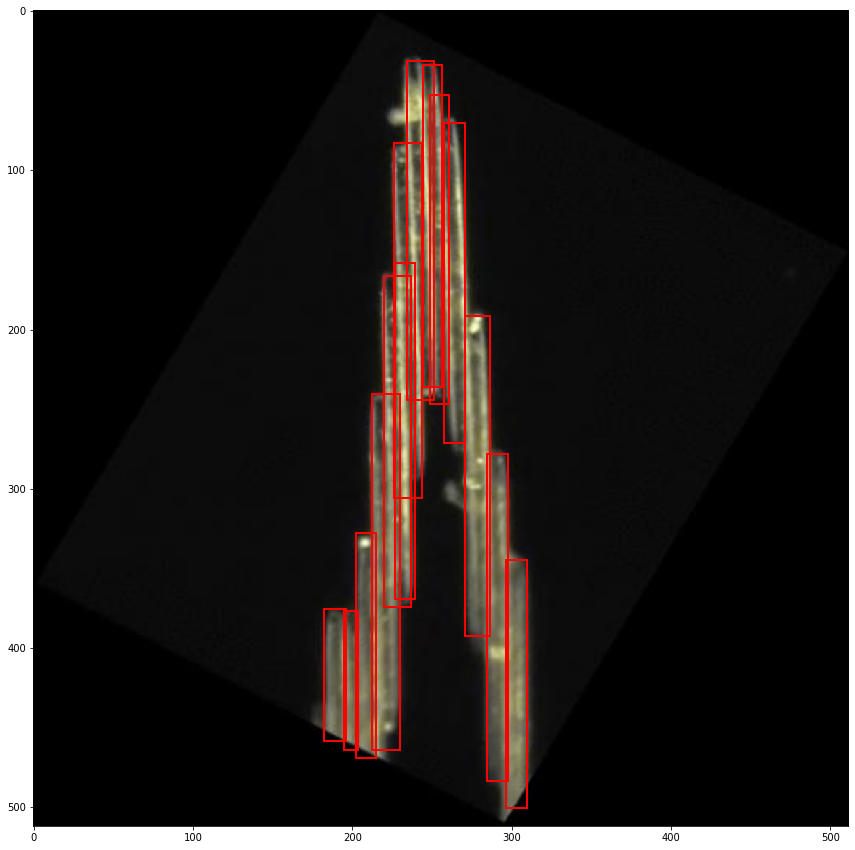

In [16]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Reading an image in default mode
image = img.mul(255).permute(1, 2, 0).byte().numpy()



fig, ax = plt.subplots(figsize=(15, 15))

# Display the image
ax.imshow(image)

for box in prediction[0]['boxes'][indc].cpu().numpy():
  ax.add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none'))



plt.show()

## Wrapping up

In this tutorial, We have learned how to create your own training pipeline for a custom dataset.

For that, we wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes. We also leveraged a Faster R-CNN model with a pre-trained ResNet 50 backbone to perform transfer learning on this new dataset.
## Future Improvement

- [ ] Evaluating Performance of model in different backbone
- [ ] Annotating more data 
- [ ] Modify Faster RCNN for detection of oriented bounding box detection. [Reference Paper](https://arxiv.org/abs/1711.10398)
- [ ] Training and Evaluating performance on Mask R-CNN


